# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

#New imports for our Pipeline workflows
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

#New imports from imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Using `Pipeline` and `FunctionTransformer`

Let's try a very simple pipeline first.

In [5]:
grab_numeric(X_train)

,Pclass,Age,SibSp,Parch,Fare
298,1,NaN,0,0,30.5000
884,3,25.00,0,0,7.0500
247,2,24.00,0,2,14.5000
478,3,22.00,0,0,7.5208
305,1,0.92,1,2,151.5500
...,...,...,...,...,...
106,3,21.00,0,0,7.6500
270,1,NaN,0,0,31.0000
860,3,41.00,2,0,14.1083
435,1,14.00,1,2,120.0000


In [4]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

In [6]:
# The FunctionTransformer will turn my function
# into a transformer.

GrabNumeric = FunctionTransformer(grab_numeric)

In [7]:
type(GrabNumeric)

sklearn.preprocessing._function_transformer.FunctionTransformer

In [8]:
pipe = Pipeline(steps=[('num', GrabNumeric), ('ss', StandardScaler() )])

In [9]:
#Now we can use our Pipeline object
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x7feaa803c790>)),
                ('ss', StandardScaler())])

In [10]:
pipe.transform(X_train)

array([[-1.62051704,         nan, -0.46765956, -0.46887833, -0.0325683 ],
       [ 0.80934914, -0.30465857, -0.46765956, -0.46887833, -0.48733085],
       [-0.40558395, -0.3735649 , -0.46765956,  2.04687047, -0.34285405],
       ...,
       [ 0.80934914,  0.79784282,  1.22097065, -0.46887833, -0.35045024],
       [-1.62051704, -1.06262827,  0.37665554,  2.04687047,  1.7030926 ],
       [-1.62051704, -0.58028391, -0.46765956,  0.78899607,  0.8747751 ]])

That looks like it worked!

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [11]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
# We'll throw these mini-pipelines into our ColumnTransformer.

#num_impute and ss are not variables we can reference, 
#but they are names by which we can use our Pipeline object to reference
subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer() ), ('ss', StandardScaler() )])
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')), 
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
#subpipe_ord = Pipeline(steps=[('ord_ohe', etc. etc.
    #and then include that in our columntransformer and change the columns being acted upon

In [25]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
298,1,male,NaN,0,0,19988,30.5000,C106,S
884,3,male,25.00,0,0,SOTON/OQ 392076,7.0500,NaN,S
247,2,female,24.00,0,2,250649,14.5000,NaN,S
478,3,male,22.00,0,0,350060,7.5208,NaN,S
305,1,male,0.92,1,2,113781,151.5500,C22 C26,S


In [14]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')

In [31]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.

CT = ColumnTransformer(transformers=[
                                        ('subpipe_num', subpipe_num, [2,3,4,6]), 
                                         ('subpipe_cat', subpipe_cat,[0,1,7,8])
                                    ],
                        remainder='drop'
                                     ) 

#when i set remainder = drop, it will drop the columns that we do not specify to act upon in my transformers

In [32]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

logreg_model_pipe = Pipeline(steps=[('ct', CT), 
                                    ('logreg', LogisticRegression(random_state=42))])

In [33]:
#Now we can use our Pipeline

#This is doing a fit and transform with all the steps except the final step. It is doing just a fit on the final step.
#In this case our final step is an estimator, so we need to give it both X_train and y_train to fit the estimator.
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar

In [34]:
logreg_model_pipe.score(X_train, y_train)

0.8398203592814372

In [ ]:
#Note we can also just feed it X_test, y_test and it'll understand how to set up those as well to get the predictions and scores

## Bringing in Our Modeling Class from before

In [35]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [36]:
log_pipe = ModelWithCV(logreg_model_pipe, model_name='log_pipe', X=X_train, y=y_train)

In [38]:
log_pipe.print_cv_summary()

CV Results for `log_pipe` model:
            0.81002 ± 0.06907 accuracy
        


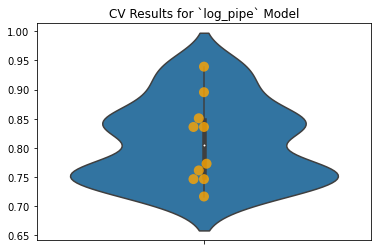

In [37]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax);

## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

In [39]:
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

In [40]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar

In [41]:
rfc_model_pipe.score(X_train, y_train)

0.9835329341317365

In [42]:
forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)

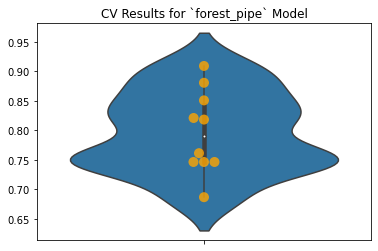

In [43]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

### Gradient Booster

In [44]:
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

In [45]:
gbc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar

In [46]:
gbc_model_pipe.score(X_train, y_train)

0.8967065868263473

In [47]:
boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train,
                         y=y_train)

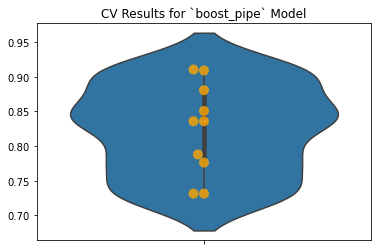

In [48]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax);

## Tuning and Cross-Validating

In [62]:
#How can we incorporate GridSearchCV?

params = {
        #the rfc at the beginning here directly matches the name we gave our estimator in our pipeline.
        #Then, we need a double underscore after that named estimator.
        #Finally, we give it the parameter name as we are used to
            'rfc__n_estimators': [50, 100, 150],
        #To tune our simple imputer strategy, we reference our column transformer first via ct__
        #Then we reference the numeric subpipe subpipe_num__
        #Then we reference the simple imputer num_impute__
        #Then we reference the strategy parameter strategy
            'ct__subpipe_num__num_impute__strategy': ['mean', 'median']
        }

In [60]:
#Alternative way to set up our params dictionary
#set up empty dictionary
params = {}
#then create key value pairs within our dictionary
params['rfc__min_samples_leaf'] = [1, 5, 10]


In [63]:
gs = GridSearchCV(estimator=rfc_model_pipe, param_grid = params, cv=10)

In [64]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [2, 3,
                                                                          4,
                                                                          6]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',

In [65]:
gs.best_params_

{'ct__subpipe_num__num_impute__strategy': 'median', 'rfc__n_estimators': 50}

In [66]:
# Mean test score for each of six models

gs.cv_results_['mean_test_score']

array([0.79366802, 0.79660787, 0.79210764, 0.80560832, 0.79660787,
       0.79066033])

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [ ]:
#Here are the imports from the top
#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline as ImPipeline

In [67]:
y_train.value_counts()

0    415
1    253
Name: Survived, dtype: int64

In [68]:
sm = SMOTE(sampling_strategy='auto',random_state=42)

In [69]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [70]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [71]:
y_train_clean.value_counts()

0    317
1    219
Name: Survived, dtype: int64

In [74]:
X_train_clean

,Pclass,Age,SibSp,Parch,Fare
884,3,25.00,0,0,7.0500
247,2,24.00,0,2,14.5000
478,3,22.00,0,0,7.5208
305,1,0.92,1,2,151.5500
316,2,24.00,1,0,26.0000
...,...,...,...,...,...
71,3,16.00,5,2,46.9000
106,3,21.00,0,0,7.6500
860,3,41.00,2,0,14.1083
435,1,14.00,1,2,120.0000


In [73]:
X_clean_resmp

,Pclass,Age,SibSp,Parch,Fare
0,3,25.000000,0,0,7.050000
1,2,24.000000,0,2,14.500000
2,3,22.000000,0,0,7.520800
3,1,0.920000,1,2,151.550000
4,2,24.000000,1,0,26.000000
...,...,...,...,...,...
629,3,24.682133,0,1,19.097726
630,2,1.340421,0,1,37.230670
631,1,38.000000,0,0,80.753064
632,1,30.632018,0,0,26.286798


In [72]:
# Even distribution

#Use SMOTE
X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

1    317
0    317
Name: Survived, dtype: int64

In [76]:
X_clean_resmp2

,Pclass,Age,SibSp,Parch,Fare
0,3,25.000000,0,0,7.050000
1,2,24.000000,0,2,14.500000
2,3,22.000000,0,0,7.520800
3,1,0.920000,1,2,151.550000
4,2,24.000000,1,0,26.000000
...,...,...,...,...,...
565,1,36.841231,1,0,54.388862
566,3,24.826498,0,1,19.063742
567,1,22.930511,2,2,262.978285
568,1,37.214068,0,0,71.171973


In [75]:
# Distribution where count of 1's = 0.8 * count of 0's

#Use the second SMOTE algorithm we set up
X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

0    317
1    253
Name: Survived, dtype: int64

In [ ]:
#Note, do not SMOTE on test data. We don't want to make fake data to test on, 
#but we want to simulate what real-world data would look like, where the class imbalance actually does exist

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [77]:
imb_pipe = ImPipeline(steps=[
                            ('ct', CT),
                            ('sm', sm),
                            ('rfc', RandomForestClassifier(random_state=42))
                            ]
                     )

In [78]:
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar

In [80]:
imb_pipe.score(X_train, y_train)

0.9835329341317365

### Gridsearching

In [82]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'sm__k_neighbors': [3, 5, 9]}

#we can pass our imblearn pipeline into grid search!
gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10)

In [83]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [2, 3,
                                                                          4,
                                                                          6]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',

In [84]:
gs.best_params_

{'rfc__criterion': 'entropy', 'rfc__min_samples_leaf': 5, 'sm__k_neighbors': 5}

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [85]:
final_model = imb_pipe

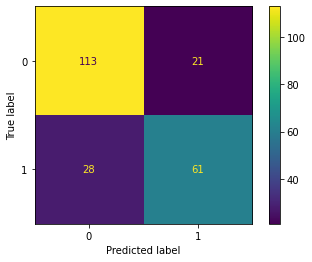

In [86]:
plot_confusion_matrix(final_model, X_test, y_test);

In [87]:
y_hat = final_model.predict(X_test)

In [88]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.78. 

Our final model's recall on the test set is 0.69 

Our final model's precision on the test set is 0.74 

Our final model's f1-score on the test is 0.71.



## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [ ]:
exos = sns.load_dataset('planets')

In [ ]:
### Your work here






